## GPU Utilization - Prophet Model Version

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import joblib
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import logging

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
logging.basicConfig(level=logging.INFO)

print("✅ Bibliotecas carregadas com sucesso!")

✅ Bibliotecas carregadas com sucesso!


In [ ]:
df = pd.read_csv("../server2.csv", parse_dates=['timestamp'], index_col='timestamp')

print(f"📋 Dados originais - Shape: {df.shape}")
print(f"📋 Colunas: {df.columns.tolist()}")
print(f"📋 Período: {df.index.min()} até {df.index.max()}")

if 'gpu_utilization' not in df.columns:
    raise ValueError("Coluna 'gpu_utilization' não encontrada!")
    
print(f"✅ Coluna 'gpu_utilization' encontrada!")
print(f"📊 Valores ausentes por coluna:\n{df.isnull().sum()}")

📋 Dados originais - Shape: (8068, 13)
📋 Colunas: ['gpu_id', 'gpu_utilization', 'memory_utilization', 'gpu_power_draw', 'gpu_temperature', 'gpu_fan_speed', 'gpu_clock_speed', 'cpu_utilization', 'memory_usage', 'server_power_draw', 'server_temperature', 'disk_usage', 'network_bandwidth']
📋 Período: 2024-03-31 00:00:00 até 2024-04-07 00:00:00
✅ Coluna 'gpu_utilization' encontrada!
📊 Valores ausentes por coluna:
gpu_id                0
gpu_utilization       0
memory_utilization    0
gpu_power_draw        0
gpu_temperature       0
gpu_fan_speed         0
gpu_clock_speed       0
cpu_utilization       0
memory_usage          0
server_power_draw     0
server_temperature    0
disk_usage            0
network_bandwidth     0
dtype: int64


In [ ]:
if len(df) > 2000: 
    print("Agregando para 5 minutos")
    agg_dict = {col: 'mean' for col in df.columns if df[col].dtype in ['float64', 'int64']}
    df = df.resample('5T').agg(agg_dict).dropna()

for col in df.select_dtypes(include=[np.number]).columns:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    df[col] = df[col].clip(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

print(f"{len(df.select_dtypes(include=[np.number]).columns)} colunas")

🔄 Detectados dados de alta frequência, agregando para 5 minutos...
✅ Dados agregados - Nova shape: (2017, 12)
🧹 Tratando outliers...
✅ Outliers tratados para 12 colunas


In [ ]:
df_prophet = df.reset_index().rename(columns={'timestamp': 'ds', 'gpu_utilization': 'y'})

regressor_mapping = {
    'gpu_power_draw': 'gpu_power_draw',
    'gpu_temperature': 'temperature', 
    'memory_utilization': 'memory_utilization',
    'cpu_utilization': 'cpu_utilization',
    'gpu_fan_speed': 'fan_speed',
    'gpu_clock_speed': 'clock_speed',
    'server_temperature': 'server_temp'
}

regressores_adicionados = []

for original_col, new_col in regressor_mapping.items():
    if original_col in df.columns:
        df_prophet[new_col] = df[original_col].values
        regressores_adicionados.append(new_col)
        print(f"➕ Regressor '{new_col}' adicionado")

# Features temporais
df_prophet['hour'] = df_prophet['ds'].dt.hour
df_prophet['day_of_week'] = df_prophet['ds'].dt.dayofweek
df_prophet['is_weekend'] = (df_prophet['ds'].dt.dayofweek >= 5).astype(int)

temporal_regressors = ['hour', 'day_of_week', 'is_weekend']
regressores_adicionados.extend(temporal_regressors)

print(f"\n📊 Total de regressores: {len(regressores_adicionados)}")
print(f"📊 Lista: {regressores_adicionados}")

➕ Regressor 'gpu_power_draw' adicionado
➕ Regressor 'temperature' adicionado
➕ Regressor 'memory_utilization' adicionado
➕ Regressor 'cpu_utilization' adicionado
➕ Regressor 'fan_speed' adicionado
➕ Regressor 'clock_speed' adicionado
➕ Regressor 'server_temp' adicionado

📊 Total de regressores: 10
📊 Lista: ['gpu_power_draw', 'temperature', 'memory_utilization', 'cpu_utilization', 'fan_speed', 'clock_speed', 'server_temp', 'hour', 'day_of_week', 'is_weekend']


In [ ]:
def optimize_prophet_params(df_train):
    """Otimiza hiperparâmetros do Prophet com fallback para parâmetros padrão"""
    best_params = None
    best_score = float('inf')
    
    default_params = {
        'changepoint_prior_scale': 0.05,
        'seasonality_prior_scale': 10.0,
        'seasonality_mode': 'additive'
    }
    
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative']
    }
    
    print("Iniciando otimização de hiperparâmetros")
    
    if len(df_train) < 100:
        print("Dados insuficientes para otimização. Usando parâmetros padrão.")
        return default_params
    
    successful_params = []
    total_combinations = len(param_grid['changepoint_prior_scale']) * len(param_grid['seasonality_prior_scale']) * len(param_grid['seasonality_mode'])
    current = 0
    
    for changepoint in param_grid['changepoint_prior_scale']:
        for seasonality in param_grid['seasonality_prior_scale']:
            for mode in param_grid['seasonality_mode']:
                current += 1
                print(f"\r🔄 Testando combinação {current}/{total_combinations}", end="")
                
                try:
                    model = Prophet(
                        changepoint_prior_scale=changepoint,
                        seasonality_prior_scale=seasonality,
                        seasonality_mode=mode,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        yearly_seasonality=False,
                        mcmc_samples=0
                    )
                    
                    basic_regressors = ['hour', 'day_of_week', 'is_weekend']
                    for reg in basic_regressors:
                        if reg in df_train.columns:
                            model.add_regressor(reg)
                    
                    model.fit(df_train)
                    
                    # Fazer uma previsão simples para avaliar
                    future = model.make_future_dataframe(periods=10, freq='5T')
                    for reg in basic_regressors:
                        if reg in df_train.columns:
                            future[reg] = df_train[reg].iloc[-1]
                    
                    forecast = model.predict(future)
                    # Score baseado na variabilidade da previsão
                    score = forecast['yhat'].std()
                    
                    successful_params.append({
                        'params': {
                            'changepoint_prior_scale': changepoint,
                            'seasonality_prior_scale': seasonality,
                            'seasonality_mode': mode
                        },
                        'score': score
                    })
                    
                    if score < best_score:
                        best_score = score
                        best_params = {
                            'changepoint_prior_scale': changepoint,
                            'seasonality_prior_scale': seasonality,
                            'seasonality_mode': mode
                        }
                
                except Exception as e:
                    continue
    
    # Se encontramos parâmetros válidos, usar o melhor
    if successful_params:
        best_result = min(successful_params, key=lambda x: x['score'])
        best_params = best_result['params']
        best_score = best_result['score']
        print(f"\n✅ Otimização concluída. Melhores parâmetros: {best_params}")
    else:
        print("Nenhuma combinação funcionou. Usando parâmetros padrão.")
        best_params = default_params
    
    return best_params

In [ ]:
# Dividir dados
train_size = int(len(df_prophet) * 0.8)
train = df_prophet[:train_size]
test = df_prophet[train_size:]

print(f"📊 Dados divididos: {len(train)} treino, {len(test)} teste")

best_params = optimize_prophet_params(train)
print(f"🎯 Melhores parâmetros: {best_params}")

📊 Dados divididos: 1613 treino, 404 teste
🔍 Iniciando otimização de hiperparâmetros...
🔄 Testando combinação 1/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/6z19n768.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/jrt9p211.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85794', 'data', 'file=/tmp/tmpy_c3d_jm/6z19n768.json', 'init=/tmp/tmpy_c3d_jm/jrt9p211.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_model_wmut2mj/prophet_model-20250528175114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/nf8umfds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/0pv7t7u0.json


🔄 Testando combinação 2/32

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8947', 'data', 'file=/tmp/tmpy_c3d_jm/nf8umfds.json', 'init=/tmp/tmpy_c3d_jm/0pv7t7u0.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_model4230psuk/prophet_model-20250528175115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/4ofjz_wf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/b83vy9vl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34826',

🔄 Testando combinação 3/32

17:51:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/5wwb7e3f.json


🔄 Testando combinação 4/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/2s7ospoq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79127', 'data', 'file=/tmp/tmpy_c3d_jm/5wwb7e3f.json', 'init=/tmp/tmpy_c3d_jm/2s7ospoq.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelbo81hgoz/prophet_model-20250528175117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/k6mv7scd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/zxst4xyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-package

🔄 Testando combinação 5/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/pi3on175.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/dz8jls30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=947', 'data', 'file=/tmp/tmpy_c3d_jm/pi3on175.json', 'init=/tmp/tmpy_c3d_jm/dz8jls30.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelzghnlnnx/prophet_model-20250528175118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


🔄 Testando combinação 6/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/_83_2kpl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/__mv2fx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7969', 'data', 'file=/tmp/tmpy_c3d_jm/_83_2kpl.json', 'init=/tmp/tmpy_c3d_jm/__mv2fx9.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_model8_lumw9g/prophet_model-20250528175119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 7/32

17:51:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/ezp4w0n5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/wfvxdvy7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39218', 'data', 'file=/tmp/tmpy_c3d_jm/ezp4w0n5.json', 'init=/tmp/tmpy_c3d_jm/wfvxdvy7.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelb8sa827t/prophet_model-20250528175119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 8/32

17:51:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/u_hecphy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/z0k774cm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78779', 'data', 'file=/tmp/tmpy_c3d_jm/u_hecphy.json', 'init=/tmp/tmpy_c3d_jm/z0k774cm.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelblfvoqhh/prophet_model-20250528175120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:20 - cmdstanpy - INFO - Chain [1] done processing


🔄 Testando combinação 9/32

INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/nciakjjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/t1u76x41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27337', 'data', 'file=/tmp/tmpy_c3d_jm/nciakjjb.json', 'init=/tmp/tmpy_c3d_jm/t1u76x41.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_model45jf9duo/prophet_model-20250528175120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 10/32

17:51:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/f0gw5l8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/nqdi9x85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23335', 'data', 'file=/tmp/tmpy_c3d_jm/f0gw5l8z.json', 'init=/tmp/tmpy_c3d_jm/nqdi9x85.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelr8a9ubj_/prophet_model-20250528175121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


🔄 Testando combinação 11/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/_08jmnjm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/4hyhc_u7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11517', 'data', 'file=/tmp/tmpy_c3d_jm/_08jmnjm.json', 'init=/tmp/tmpy_c3d_jm/4hyhc_u7.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelrg5sb8s9/prophet_model-20250528175121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 12/32

17:51:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/6t5wm640.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/l1a2ziii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6914', 'data', 'file=/tmp/tmpy_c3d_jm/6t5wm640.json', 'init=/tmp/tmpy_c3d_jm/l1a2ziii.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelk_wh4w76/prophet_model-20250528175122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


🔄 Testando combinação 13/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/4mnzagvh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/ivyy73hz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72370', 'data', 'file=/tmp/tmpy_c3d_jm/4mnzagvh.json', 'init=/tmp/tmpy_c3d_jm/ivyy73hz.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelzgm0z1g6/prophet_model-20250528175123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 14/32

17:51:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/ntfn6znn.json


🔄 Testando combinação 15/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/m9k_mn61.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20543', 'data', 'file=/tmp/tmpy_c3d_jm/ntfn6znn.json', 'init=/tmp/tmpy_c3d_jm/m9k_mn61.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modeli9wy0u_9/prophet_model-20250528175123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/iq7f3m9p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/pel5iwqv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-package

🔄 Testando combinação 16/32

17:51:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/dnea_qwt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/aw8dy3d6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30412', 'data', 'file=/tmp/tmpy_c3d_jm/dnea_qwt.json', 'init=/tmp/tmpy_c3d_jm/aw8dy3d6.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_model100hn0uf/prophet_model-20250528175124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 17/32

17:51:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/8js802bi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/dz8ubphr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40881', 'data', 'file=/tmp/tmpy_c3d_jm/8js802bi.json', 'init=/tmp/tmpy_c3d_jm/dz8ubphr.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelp5mu2oyf/prophet_model-20250528175125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 18/32

17:51:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/qtvbyk9x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/dj4xfx4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98094', 'data', 'file=/tmp/tmpy_c3d_jm/qtvbyk9x.json', 'init=/tmp/tmpy_c3d_jm/dj4xfx4l.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_model38uunj2h/prophet_model-20250528175126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 19/32

17:51:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/w39kjsg5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/l9io96rr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87161', 'data', 'file=/tmp/tmpy_c3d_jm/w39kjsg5.json', 'init=/tmp/tmpy_c3d_jm/l9io96rr.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_model83oqyro0/prophet_model-20250528175126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 20/32

17:51:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/0qtyzink.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/k7_5vq41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20860', 'data', 'file=/tmp/tmpy_c3d_jm/0qtyzink.json', 'init=/tmp/tmpy_c3d_jm/k7_5vq41.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelhzivgat6/prophet_model-20250528175127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 21/32

17:51:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/xif2f_9t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/s2tw60u7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40661', 'data', 'file=/tmp/tmpy_c3d_jm/xif2f_9t.json', 'init=/tmp/tmpy_c3d_jm/s2tw60u7.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelhabd8rus/prophet_model-20250528175128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 22/32

17:51:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/llmq_kh0.json


🔄 Testando combinação 23/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/jk7cn9xg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54231', 'data', 'file=/tmp/tmpy_c3d_jm/llmq_kh0.json', 'init=/tmp/tmpy_c3d_jm/jk7cn9xg.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modeltyrfyx_8/prophet_model-20250528175130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/dvxwk145.json


🔄 Testando combinação 24/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/s8et9le_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23488', 'data', 'file=/tmp/tmpy_c3d_jm/dvxwk145.json', 'init=/tmp/tmpy_c3d_jm/s8et9le_.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modeluartryzp/prophet_model-20250528175131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/h3dws98j.json


🔄 Testando combinação 25/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/uozh_9ng.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63028', 'data', 'file=/tmp/tmpy_c3d_jm/h3dws98j.json', 'init=/tmp/tmpy_c3d_jm/uozh_9ng.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelkgej8rht/prophet_model-20250528175132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/5u35xdx9.json


🔄 Testando combinação 26/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/gwj0vw_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87683', 'data', 'file=/tmp/tmpy_c3d_jm/5u35xdx9.json', 'init=/tmp/tmpy_c3d_jm/gwj0vw_h.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modeljxtvyrc0/prophet_model-20250528175134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/aw9olbm9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/h496xjo3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-package

🔄 Testando combinação 27/32

17:51:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/36snr5ai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/zinlbvl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94669', 'data', 'file=/tmp/tmpy_c3d_jm/36snr5ai.json', 'init=/tmp/tmpy_c3d_jm/zinlbvl8.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modeluu44_6g8/prophet_model-20250528175136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 28/32

17:51:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/68k7mnf0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/fyb2c5wp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89626', 'data', 'file=/tmp/tmpy_c3d_jm/68k7mnf0.json', 'init=/tmp/tmpy_c3d_jm/fyb2c5wp.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modelz2uw81wb/prophet_model-20250528175137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 29/32

17:51:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/_x7h934c.json


🔄 Testando combinação 30/32

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/l00ohmz9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58679', 'data', 'file=/tmp/tmpy_c3d_jm/_x7h934c.json', 'init=/tmp/tmpy_c3d_jm/l00ohmz9.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_model_znubvgv/prophet_model-20250528175138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/t2m3yvlc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/bqz3gjvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-package

🔄 Testando combinação 31/32

17:51:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/2w6kpwtg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/maq1j28i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13788', 'data', 'file=/tmp/tmpy_c3d_jm/2w6kpwtg.json', 'init=/tmp/tmpy_c3d_jm/maq1j28i.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_model7vozoa16/prophet_model-20250528175139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🔄 Testando combinação 32/32

17:51:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



✅ Otimização concluída. Melhores parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
🎯 Melhores parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [ ]:
# Criar modelo final
model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'], 
    seasonality_mode=best_params['seasonality_mode'],
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    mcmc_samples=0
)

# Adicionar todos os regressores
for regressor in regressores_adicionados:
    model.add_regressor(regressor)
    print(f"➕ Regressor '{regressor}' adicionado ao modelo")

print("Treinando modelo")
model.fit(train)
print("Treinamento concluído!")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/fyuhs0cc.json


➕ Regressor 'gpu_power_draw' adicionado ao modelo
➕ Regressor 'temperature' adicionado ao modelo
➕ Regressor 'memory_utilization' adicionado ao modelo
➕ Regressor 'cpu_utilization' adicionado ao modelo
➕ Regressor 'fan_speed' adicionado ao modelo
➕ Regressor 'clock_speed' adicionado ao modelo
➕ Regressor 'server_temp' adicionado ao modelo
➕ Regressor 'hour' adicionado ao modelo
➕ Regressor 'day_of_week' adicionado ao modelo
➕ Regressor 'is_weekend' adicionado ao modelo

🔥 Treinando modelo...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_c3d_jm/jt_1z2qv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/gabriel/l/AI_api/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4340', 'data', 'file=/tmp/tmpy_c3d_jm/fyuhs0cc.json', 'init=/tmp/tmpy_c3d_jm/jt_1z2qv.json', 'output', 'file=/tmp/tmpy_c3d_jm/prophet_modeleyk9jerj/prophet_model-20250528175141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Treinamento concluído!


## 📈 Avaliação e Predição

In [27]:
print("🔮 Gerando previsões...")
future = model.make_future_dataframe(periods=len(test), freq='5T')

for regressor in regressores_adicionados:
    if regressor in df_prophet.columns:
        future[regressor] = df_prophet[regressor].values[:len(future)]
    else:
        future[regressor] = 0

forecast = model.predict(future)
test_forecast = forecast.iloc[train_size:]

mae = mean_absolute_error(test['y'], test_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], test_forecast['yhat']))
r2 = r2_score(test['y'], test_forecast['yhat'])

print(f"\n📊 MÉTRICAS DO MODELO:")
print(f"{'='*50}")
print(f"📉 MAE (Erro Médio Absoluto): {mae:.4f}%")
print(f"📉 RMSE (Raiz do Erro Quadrático): {rmse:.4f}%")
print(f"📊 R² (Coeficiente de Determinação): {r2:.4f}")
print(f"🔧 Regressores utilizados: {len(regressores_adicionados)}")
print(f"{'='*50}")

if r2 > 0.9:
    quality = "EXCELENTE"
elif r2 > 0.7:
    quality = "BOA"
elif r2 > 0.5:
    quality = "REGULAR"
else:
    quality = "RUIM"

print(f"🎯 Qualidade do modelo: {quality}")

🔮 Gerando previsões...

📊 MÉTRICAS DO MODELO:
📉 MAE (Erro Médio Absoluto): 1.0849%
📉 RMSE (Raiz do Erro Quadrático): 1.3856%
📊 R² (Coeficiente de Determinação): 0.9739
🔧 Regressores utilizados: 10
🎯 Qualidade do modelo: EXCELENTE


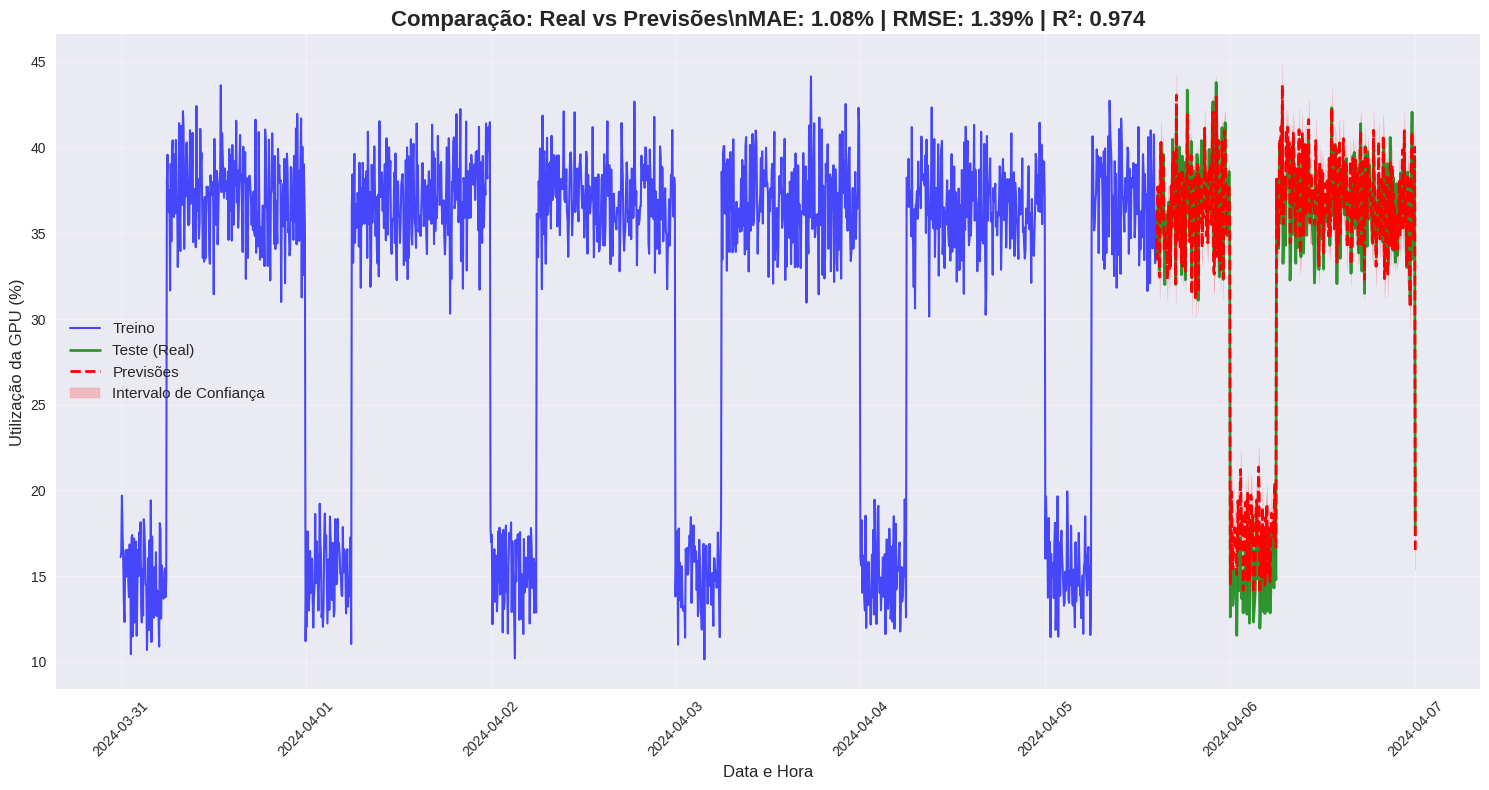

In [28]:
plt.figure(figsize=(15, 8))

# Dados de treino e teste
plt.plot(train['ds'], train['y'], label='Treino', color='blue', alpha=0.7, linewidth=1.5)
plt.plot(test['ds'], test['y'], label='Teste (Real)', color='green', alpha=0.8, linewidth=2)
plt.plot(test['ds'], test_forecast['yhat'], label='Previsões', color='red', linestyle='--', linewidth=2)

# Intervalo de confiança
plt.fill_between(test['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], 
                 color='red', alpha=0.2, label='Intervalo de Confiança')

plt.title(f'Comparação: Real vs Previsões\\nMAE: {mae:.2f}% | RMSE: {rmse:.2f}% | R²: {r2:.3f}', 
          fontsize=16, fontweight='bold')
plt.xlabel('Data e Hora', fontsize=12)
plt.ylabel('Utilização da GPU (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

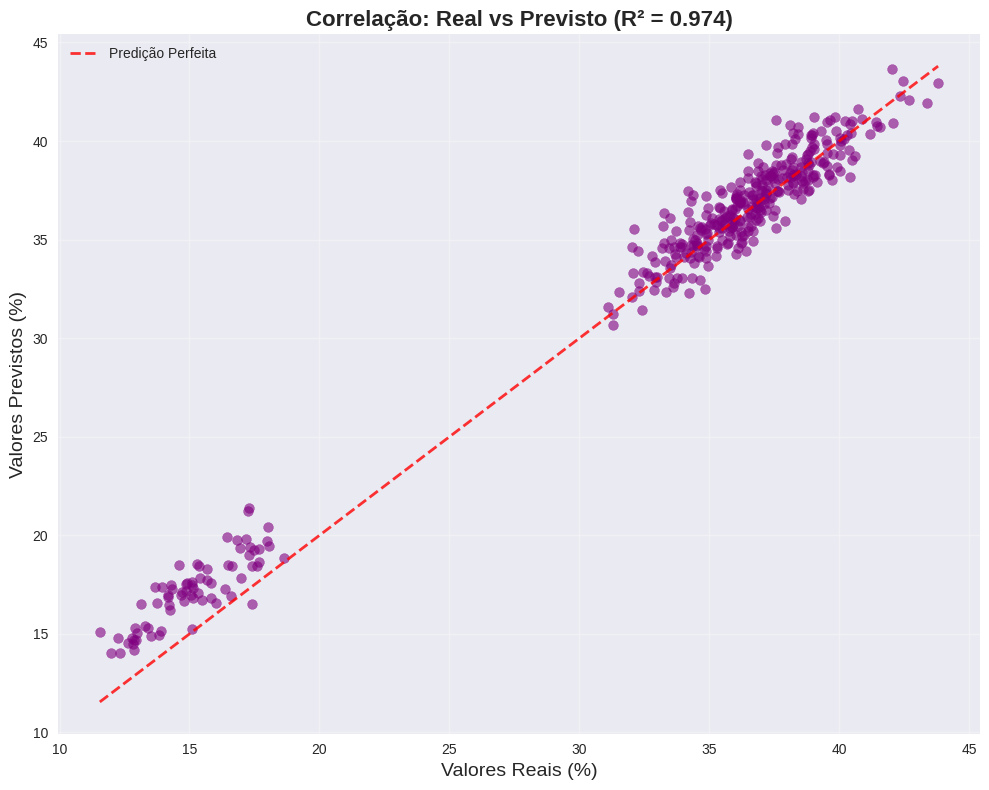

In [ ]:
# Scatter plot Real vs Previsto
plt.figure(figsize=(10, 8))

plt.scatter(test['y'], test_forecast['yhat'], alpha=0.6, color='purple', s=50)

min_val = min(test['y'].min(), test_forecast['yhat'].min())
max_val = max(test['y'].max(), test_forecast['yhat'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Predição Perfeita')

plt.xlabel('Valores Reais (%)', fontsize=14)
plt.ylabel('Valores Previstos (%)', fontsize=14)
plt.title(f'Correlação: Real vs Previsto (R² = {r2:.3f})', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Gráfico 3

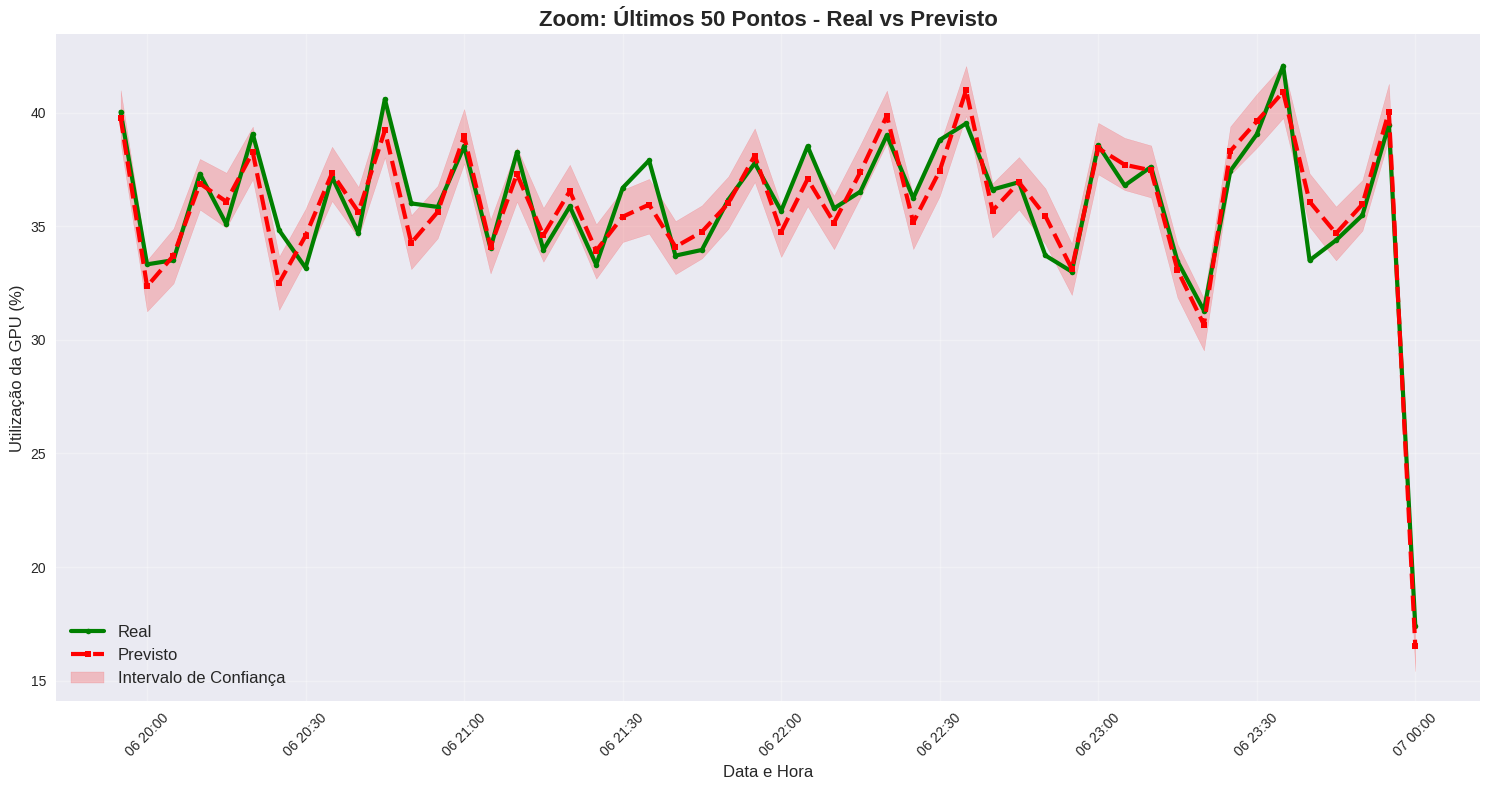

In [31]:
plt.figure(figsize=(15, 8))

n_points = min(50, len(test))
test_subset = test.tail(n_points)
forecast_subset = test_forecast.tail(n_points)

plt.plot(test_subset['ds'], test_subset['y'], 
         label='Real', color='green', linewidth=3, marker='o', markersize=4)
plt.plot(test_subset['ds'], forecast_subset['yhat'], 
         label='Previsto', color='red', linewidth=3, linestyle='--', marker='s', markersize=4)

plt.fill_between(test_subset['ds'], 
                 forecast_subset['yhat_lower'], 
                 forecast_subset['yhat_upper'], 
                 color='red', alpha=0.2, label='Intervalo de Confiança')

plt.title(f'Zoom: Últimos {n_points} Pontos - Real vs Previsto', fontsize=16, fontweight='bold')
plt.xlabel('Data e Hora', fontsize=12)
plt.ylabel('Utilização da GPU (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [33]:
model_data = {
    'model': model,
    'regressors': regressores_adicionados,
    'best_params': best_params,
    'metrics': {'mae': mae, 'rmse': rmse, 'r2': r2},
    'data_frequency': '5T',
    'version': '2.0_optimized',
    'column_mapping': regressor_mapping
}

joblib.dump(model_data, './prophet_model_optimized.pkl')
print("💾 Modelo otimizado salvo em 'prophet_model_optimized.pkl'!")

💾 Modelo otimizado salvo em 'prophet_model_optimized.pkl'!
